In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from ModelSelection import *
from NeuralNetwork import *
from MyUtils import *

In [2]:
tr_df = pd.read_csv('../data/monks_csv/monks_tr_1.csv', index_col=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
len_training = len(tr_df)
test_df = pd.read_csv('../data/monks_csv/monks_ts_1.csv', index_col=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True) # test in realtà ma va be
len_test = len(test_df)
len_dataset = len_training + len_test
test_df.head(2)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1
0,3,2,1,1,3,1,0
1,1,3,1,2,1,2,1


In [3]:
def OHE(df):
    OHE = pd.get_dummies(df, columns=['input_'+str(i) for i in range(1, 7)])
    OHE = OHE.set_axis(['output_1'] + ['input_' + str(i) for i in range(1, len(OHE.columns))], axis=1)
    cols = OHE.columns.tolist()
    cols = cols[1:] + cols[:1]
    OHE = OHE[cols]
    return OHE

In [4]:
tr_df_OHE = OHE(tr_df)
test_df_OHE = OHE(test_df)

From monk database:

Attribute information:
1. class: 0, 1 
2. a1:    1, 2, 3
3. a2:    1, 2, 3
4. a3:    1, 2
5. a4:    1, 2, 3
6. a5:    1, 2, 3, 4
7. a6:    1, 2
8. Id:    (A unique symbol for each instance)

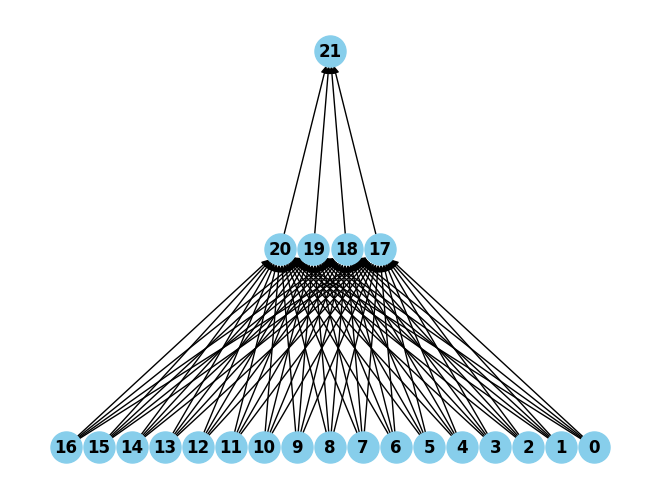

In [5]:
TR_INPUT = len(tr_df_OHE.columns) - 1
TR_OUTPUT = 1
hidden_len = 4
topology = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [['sigmoid', [1]]]*hidden_len + [['sigmoid', [1]]])
NeuralNetwork.display_topology(topology)

In [6]:
training_set = tr_df_OHE.values[:int(len_training/5)]
validation_set = tr_df_OHE.values[int(len_training/5):]
test_set = test_df_OHE.values

In [7]:
len(training_set[-1].shape)

1

In [8]:
validation_set[:,TR_INPUT:].shape

(100, 1)

In [9]:
np.seterr('raise')
MS = ModelSelection('../data/gs_data/monk_1_test_kf.csv')

MS.default_values['metrics'] = [ErrorFunctions.accuracy, ErrorFunctions.mean_squared_error]
hyperparam_grid = {
    'lambda_tikhonov':[0],
    'batch_size':[20,50],
    'min_epochs': [50],
    'max_epochs':[2],#00, 600],
    
    'error_increase_tolerance':[np.inf], #don't want early stopping
    'patience':[5], 
    
    'topology': [str(topology)],
    
    'learning_rate':[0.3,0.5,0.6],
    'alpha_momentum':[0.4,0.5,0.6],
    
    'adamax' : [True, False],
    'adamax_learning_rate' : [0.05, 0.1, 0.2],
}

constr = {'adamax': (lambda x: x, ['learning_rate', 'alpha_momentum'], ['adamax_learning_rate'])}

MS.grid_searchKF(tr_df_OHE.values, hyperparam_grid, 4, 8, False, constr)

Already done:  0
tot conf: 24
remaining conf: 24
tot conf to do: 24
pid: 66960  started new kfold 1 / 3
{'nesterov': False, 'adamax_learning_rate': 0.0001, 'alpha_momentum': 0.4, 'minibatch_size': 20, 'lr_decay_tau': 0.0, 'learning_rate': 0.015, 'max_epochs': 2, 'eta_tau': 0.00015, 'error_increase_tolerance': inf, 'training_set_len': 93, 'retraing_es_error': -1, 'patience': 5, 'min_epochs': 50, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'lambda_tikhonov': 0, 'adamax': False, 'epochs': [2, 2, 2, 2], 'mean_metrics': [0.5, 0.25736516644725266], 'variance_metrics': [0.003381893860561915, 9.898879188936672e-05], 'mean_best_validation_training_error': 0.25778793169980396}
pid: 66960  started new kfold 2 / 3
{'nesterov': False, 'adamax_learning_rate': 0.002, 'alpha_momentum': 0.5, 'minibatch_size': 50, 'lr_decay_tau': 0.0, 'learning_rate': 0.002, 'max_epochs': 2, 'eta_tau': 2e-05, 'error_increase_tolerance': inf, 'training_set_len': 93, 'retraing_es_error': -1, 'patience': 5, 'min_ep

In [10]:
results_files = ['monk_1_test_kf.csv']
topologies = ['4_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)

orig_df = pd.concat(gs_results)
orig_df.head(1)

,adamax,adamax_learning_rate,alpha_momentum,batch_size,error_increase_tolerance,lambda_tikhonov,learning_rate,max_epochs,min_epochs,patience,topology,stats,mean_accuracy,mean_mean_squared_error,var_accuracy,var_mean_squared_error,mean_best_validation_training_error
0,False,0.002,0.4,50,inf,0,0.3,2,50,5,4_sigmoid,"{'nesterov': False, 'adamax_learning_rate': 4e...",0.516129,0.260358,0.001561,0.000391,0.264195


In [11]:
columns_order = [x for x in COLUMNS_ORDER if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_accuracy'
orig_df.sort_values(by=[order_by], ascending=False, inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [12]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [13]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
#warnings.simplefilter(action='default', category=FutureWarning)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [14]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [15]:
error_treshold = 0.01
gs_results_clean = gs_results.loc[(gs_results['mean_accuracy'].notna()) & (gs_results['mean_accuracy'] > error_treshold)].copy()

gs_results_clean = gs_results_clean.reset_index(drop=True)
gs_results_clean.drop('error_increase_tolerance', axis=1).style.background_gradient(cmap='Blues')

,topology,batch_size,min_epochs,max_epochs,patience,lambda_tikhonov,learning_rate,alpha_momentum,adamax,adamax_learning_rate,mean_mean_squared_error,var_mean_squared_error,mean_accuracy,var_accuracy,mean_best_validation_training_error
0,4_sigmoid,50.000000,50.000000,2.000000,5.000000,0.000000,0.600000,0.600000,0.000000,nan,0.245337,0.000059,0.556452,0.006959,0.257456
1,4_sigmoid,50.000000,50.000000,2.000000,5.000000,0.000000,0.300000,0.400000,0.000000,nan,0.260358,0.000391,0.516129,0.001561,0.264195
2,4_sigmoid,50.000000,50.000000,2.000000,5.000000,0.000000,0.600000,0.500000,0.000000,nan,0.254926,0.000145,0.508065,0.003837,0.254315
3,4_sigmoid,50.000000,50.000000,2.000000,5.000000,0.000000,nan,nan,1.000000,0.050000,0.261943,0.000501,0.508065,0.003317,0.255650
4,4_sigmoid,20.000000,50.000000,2.000000,5.000000,0.000000,0.300000,0.600000,0.000000,nan,0.251082,0.000017,0.500000,0.008585,0.250446
5,4_sigmoid,20.000000,50.000000,2.000000,5.000000,0.000000,nan,nan,1.000000,0.200000,0.261469,0.000084,0.500000,0.003382,0.270447
6,4_sigmoid,20.000000,50.000000,2.000000,5.000000,0.000000,0.300000,0.400000,0.000000,nan,0.257365,0.000099,0.500000,0.003382,0.257788
7,4_sigmoid,20.000000,50.000000,2.000000,5.000000,0.000000,nan,nan,1.000000,0.050000,0.292051,0.000003,0.500000,0.003382,0.300162
8,4_sigmoid,20.000000,50.000000,2.000000,5.000000,0.000000,nan,nan,1.000000,0.100000,0.269868,0.000994,0.500000,0.003382,0.268564
9,4_sigmoid,50.000000,50.000000,2.000000,5.000000,0.000000,0.500000,0.600000,0.000000,nan,0.263606,0.000561,0.491935,0.005398,0.255606


In [16]:
#  best performance
n_best_fem = 1
sorting_values_col = ['mean_accuracy']
interesting_index = []
for i in topologies_dict:
    for col in sorting_values_col:
        interesting_index += list(orig_df.loc[orig_df['topology'] == i].sort_values([col]).head(n_best_fem).index)
    #interesting_index.insert(orig_df.loc[orig_df['topology'] == i].sort_values(['mean_mean_euclidean_error']).head(n_best_fem).index)
#interesting_index = list(orig_df['topology'].drop_duplicates().index)
orig_df.iloc[interesting_index]

,topology,stats,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,adamax,adamax_learning_rate,mean_mean_squared_error,var_mean_squared_error,mean_accuracy,var_accuracy,mean_best_validation_training_error
23,4_sigmoid,"{'nesterov': False, 'adamax_learning_rate': 0....",20,50,2,5,inf,0,0.6,0.5,False,0.002,0.258632,0.000155,0.41129,0.002797,0.247724


In [27]:
def construct_obj(folder, index_list, df):
    interesting_model = []
    for i in index_list:
        
        dummy = {}
        dummy['nn_file_name'] = folder + df.iloc[i]['topology'] + '_' + str(i) + '.json'
        dummy['index'] = i
        df['metrics'] = [[ErrorFunctions.accuracy, ErrorFunctions.mean_squared_error]]*len(df)
        nn, stats = train_from_index(df, training_set, validation_set, i, topologies_dict)
        dummy['model'] = nn
        dummy['stats'] = stats
        
        dummy['top_name'] = df.iloc[i]['topology']
        
        dummy['prediction_tr'] = nn.predict_array(training_set[:,:TR_INPUT])
        dummy['prediction_val'] = nn.predict_array(validation_set[:,:TR_INPUT])
        dummy['prediction_test'] = nn.predict_array(test_set[:,:TR_INPUT])
            
        dummy['tr_acc'] = ErrorFunctions.accuracy(dummy['prediction_tr'], training_set[:,TR_INPUT:])
        dummy['val_acc'] = ErrorFunctions.accuracy(dummy['prediction_val'], validation_set[:,TR_INPUT:])
        dummy['test_acc'] = ErrorFunctions.accuracy(dummy['prediction_test'], test_set[:,TR_INPUT:])

        interesting_model.append(dummy)
        
    return interesting_model

In [28]:
interesting_model = construct_obj('../data/net/monk_1/', interesting_index, orig_df)

starting values:  {'training_set_len': 24, 'minibatch_size': 20, 'max_epochs': 2, 'retraing_es_error': 0.2477237255496311, 'error_increase_tolerance': inf, 'patience': 5, 'min_epochs': 50, 'learning_rate': 0.03, 'lr_decay_tau': 1550.0, 'eta_tau': 0.0003, 'lambda_tikhonov': 0, 'alpha_momentum': 0.5, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.0001, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999997), 'mean_epoch_train_time': 0, 'units_weights': {20: [], 19: [], 18: [], 17: [], 21: []}, 'units_weights_batch': {}, 'training_accuracy': [], 'validation_accuracy': [], 'training_mean_squared_error': [], 'validation_mean_squared_error': []}
[1/2] tr time: 0:00:00.026451 | accuracy: tr=0.375 val=0.53 | | mean_squared_error: tr=0.29949497661702223 val=0.2588992233025259 | 
[2/2] tr time: 0:00:00.006703 | accuracy: tr=0.375 val=0.53 | | mean_squ

In [29]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [30]:
with open('../data/net/monk_1/models.json', 'w+') as file:
    save_obj(interesting_model, file)

In [31]:
interesting_model = load_obj('../data/net/monk_1/models.json')

In [32]:
interesting_model[0]['stats'].keys()

dict_keys(['training_set_len', 'minibatch_size', 'max_epochs', 'retraing_es_error', 'error_increase_tolerance', 'patience', 'min_epochs', 'learning_rate', 'lr_decay_tau', 'eta_tau', 'lambda_tikhonov', 'alpha_momentum', 'nesterov', 'adamax', 'adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2', 'best_validation_training_error', 'epochs', 'total_train_time', 'mean_epoch_train_time', 'units_weights', 'units_weights_batch', 'training_accuracy', 'validation_accuracy', 'training_mean_squared_error', 'validation_mean_squared_error'])

In [37]:
df_im = pd.DataFrame(interesting_model)
def take_data(x):
    cols = ['training_mean_squared_error','validation_mean_squared_error','training_accuracy','validation_accuracy']
    cols_name = ['tmse','vmse','ra','va']
    for i, c in enumerate(cols):
        x[cols_name[i]] = x['stats'][c]
        
    return x
df_im = df_im.apply(take_data, axis=1)
df_im = df_im.drop(['stats'], axis=1)

In [38]:
df_im

,nn_file_name,index,model,top_name,prediction_tr,prediction_val,prediction_test,tr_acc,val_acc,test_acc,tmse,vmse,ra,va
0,../data/net/monk_1/4_sigmoid_23.json,23,id: 20 w: [-0.12940647 -0.06129429 -0.08445318...,4_sigmoid,[[0.59321985]\n [0.59100288]\n [0.58876453]\n ...,[[0.59543744]\n [0.5887398 ]\n [0.59326305]\n ...,[[0.59641529]\n [0.59164703]\n [0.5963957 ]\n ...,0.375,0.53,0.5,"[0.29949497661702223, 0.2807415410145822]","[0.2588992233025259, 0.25215504247859044]","[0.375, 0.375]","[0.53, 0.53]"


KeyError: 'training_mean_euclidean_error'

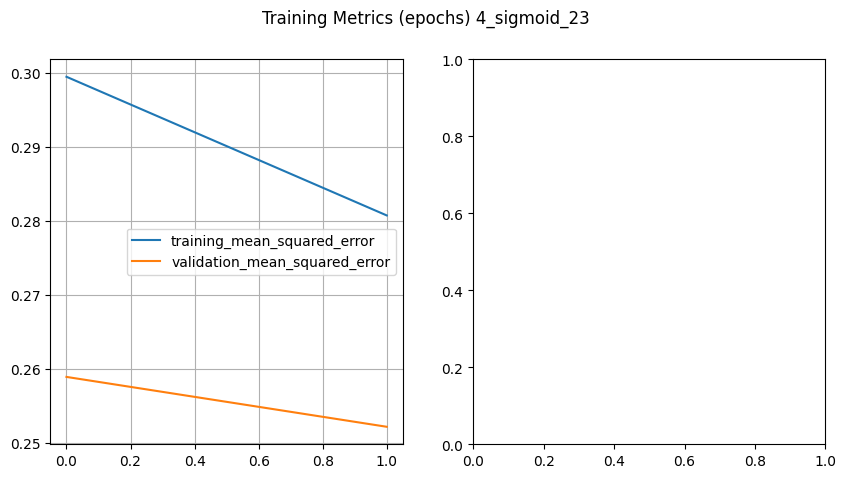

In [39]:
metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error]
for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs) ' + dummy['top_name'] + '_' + str(dummy['index']))
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])

In [ ]:
dic_list = []
for dummy in interesting_model:
    dic = {}
    dic[dummy['top_name'] + 'tmse'] = dummy['stats']['training_mean_squared_error']
    dic[dummy['top_name'] + 'vmse'] = dummy['stats']['validation_mean_squared_error']
    dic[dummy['top_name'] + 'tmee'] = dummy['stats']['training_mean_euclidean_error']
    dic[dummy['top_name'] + 'vmee'] = dummy['stats']['validation_mean_euclidean_error']
    dic_list.append(pd.DataFrame(dic))
    
for i in dic_list:
    fig = px.line(i)
    fig.show()

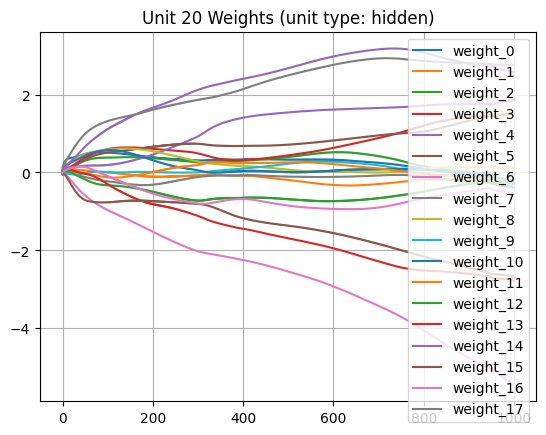

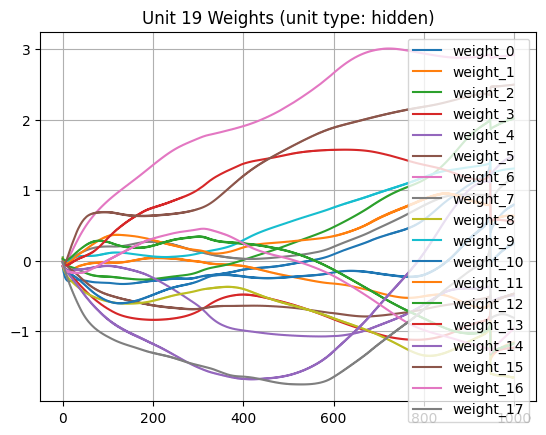

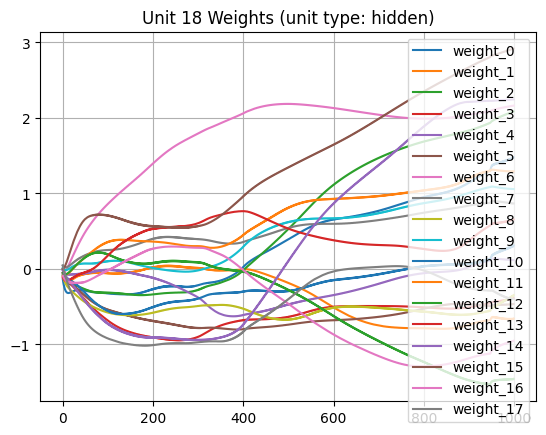

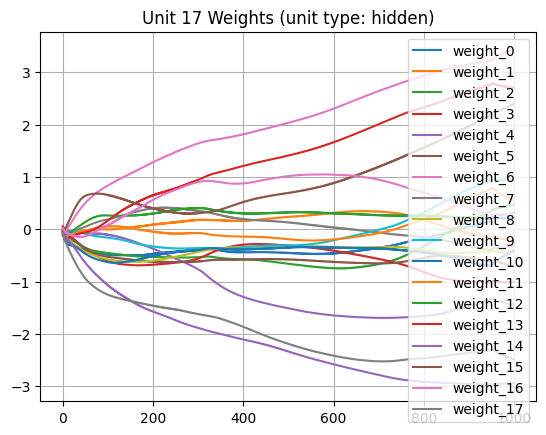

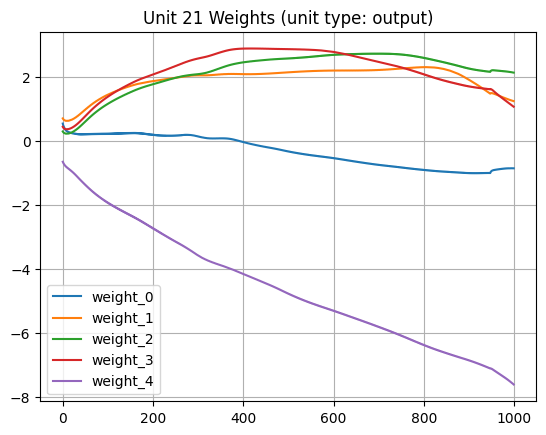

In [ ]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')